---
title: Bloomberg Market Moving News - Classifier
collapse: 3
parent: 2022 December (NLP)
---

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from joblib import dump

from alpha_tools.thoth.metrics import get_topk, word_ranking
from alpha_tools.thoth.bbg.get_bb_data_one_tag import get_bb_data_one_tag

np.random.seed(999)

/home/yzhong/conda/envs/env_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'alpha_tools'

# 0. Parameters and data loading

## A. Parameters (user needs to define)

In [3]:
#file_path = "/mnt/tmp/tmp31d/jlhour/spark_database/BFW_news" # path where the data is located
feature_name = "Market Moving News" # Name of the feature, can be anything you want
feature_col = "MMN" # Name of the boolean column in the dataframe
text_col = "clean_headline" # Name of the str column where the text you want to analyze is located
save_classifier = False # If True, saves the sklearn classifier
output_dir = None # Where to save the classifier

## B. Data loading

In [ ]:
df = get_bb_data_one_tag(tag=feature_col, date="*/*/*", save=False)
df_past = df[df["year"].isin(range(2008, 2017))]

## C. Downsampling to achieve a balanced dataset (for training the classifier)

In [6]:
sampling_prob = df_past[feature_col].mean() / (1-df_past[feature_col].mean())
n = len(df_past)
selector = (df_past[feature_col] | (np.random.rand(n) < sampling_prob))

ds_df = df_past[selector]
print("Frequency of {} news in the downsampled dataframe: {:.3f}".format(feature_name, ds_df[feature_col].mean()))

Frequency of Market Moving News news in the downsampled dataframe: 0.502


# 1. Basic descriptive statistics

Frequency of Market Moving News news : 0.000


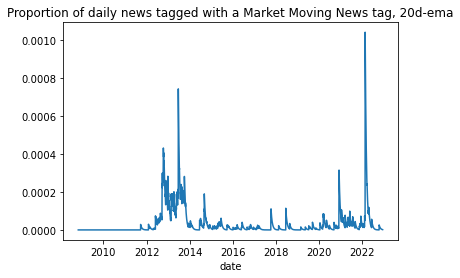

In [7]:
df.groupby("date")[feature_col].mean().ewm(20).mean().plot(title=f'Proportion of daily news tagged with a {feature_name} tag, 20d-ema')
print("Frequency of {} news : {:.3f}".format(feature_name, df_past[feature_col].mean()))

In [8]:
md("# 2. Word frequency by {} vs. Other".format(feature_name))

# 2. Word frequency by Market Moving News vs. Other

In [9]:
md("This is a plot of the word frequency in news tagged as {} vs. other news.".format(feature_name))

This is a plot of the word frequency in news tagged as Market Moving News vs. other news.

In [10]:
c_vectorizer = CountVectorizer(
    strip_accents = 'unicode',
    stop_words="english"
)

freq_dict = {}
for switch in [True, False]:
    X = c_vectorizer.fit_transform(ds_df.loc[ds_df[feature_col] == switch, text_col]).mean(0)
    frequency = pd.DataFrame(X.transpose(), index=c_vectorizer.get_feature_names_out())
    frequency.columns = ['frequency']
    
    if switch:
        freq_dict[feature_name.replace(" ", "_")] = frequency.sort_values('frequency')
    else:
        freq_dict["OTHER"] = frequency.sort_values('frequency')

freq_df = pd.concat(freq_dict, axis=1).fillna(0.).droplevel(axis=1, level=1)

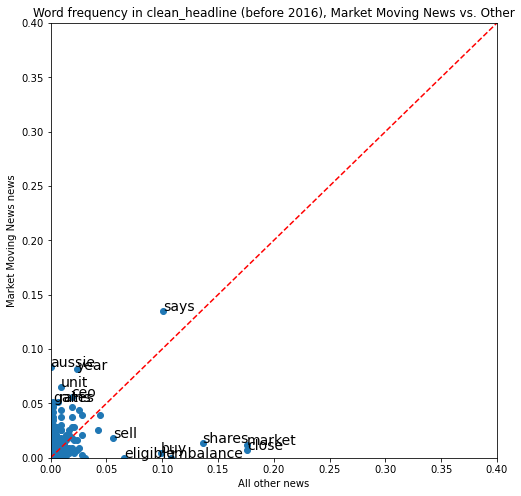

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(freq_df["OTHER"], freq_df[feature_name.replace(" ", "_")])
ax.set_title(f'Word frequency in {text_col} (before 2016), {feature_name} vs. Other')
ax.set_xlabel('All other news')
ax.set_ylabel(f'{feature_name} news')
ax.set_xlim([0, .4])
ax.set_ylim([0, .4])
ax.axline([0, 0], [1, 1], color="red", linestyle="--")

for i, txt in enumerate(freq_df.index):
    if (freq_df.iloc[i] > .05).any() :
        ax.annotate(txt, (freq_df.loc[txt, 'OTHER'], freq_df.loc[txt, feature_name.replace(" ", "_")]), size=14)

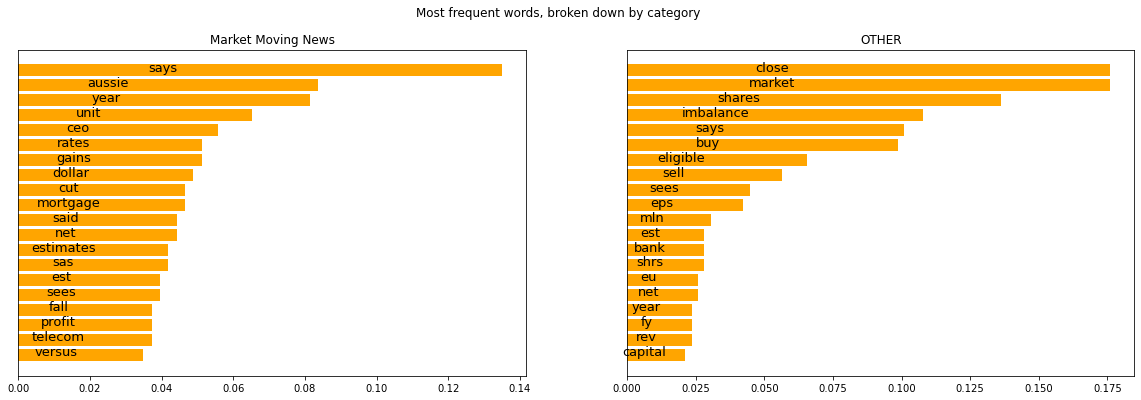

In [12]:
k = 20
freq_rankings = {}
for col in freq_df.columns:
    freq_rankings[col] = freq_df.sort_values(col, ascending=False)[col].head(20).to_dict()
    
word_ranking(
    freq_rankings["OTHER"],
    freq_rankings[feature_name.replace(" ", "_")],
    title="Most frequent words, broken down by category",
    reverse_top=True,
    reverse_bottom=True,
    left_title=feature_name,
    right_title="OTHER"
)

# 3. Training a linear classifier

## A. Definition and train

In [13]:
vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    stop_words='english',
    max_features=4_096,
    token_pattern=r"(?u)\b\w{3,}\b", # On ne garde que les tokens de trois lettres au moins
)

estimator = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', LogisticRegressionCV(
        max_iter=1000
    ))
])

In [14]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    ds_df[text_col],
    ds_df[feature_col],
    train_size=.8,
    random_state=42
)

estimator.fit(X_train, y_train)

stats = {
    'train_size': len(X_train),
    'test_size': len(X_test),
    'nb_features': len(estimator.named_steps['vectorizer'].get_feature_names_out()),
    'train_accuracy': estimator.score(X_train, y_train),
    'test_accuracy': estimator.score(X_test, y_test)
}

y_score = estimator.decision_function(X_test)

if save_classifier:
    dump(estimator, f"{output_dir}/news_classifier_{feature_name}.joblib") 

CPU times: user 779 ms, sys: 14.9 ms, total: 794 ms
Wall time: 815 ms


## B. Performance (Accuracy, ROC curve etc.)

In [15]:
print("Performance of the classifier :")
for k, v in stats.items():
    if isinstance(v, float):
        print("    - {}: {:.3f}".format(k, v))
    else:
        print(f"    - {k}: {v}")

Performance of the classifier :
    - train_size: 684
    - test_size: 172
    - nb_features: 1798
    - train_accuracy: 1.000
    - test_accuracy: 0.802


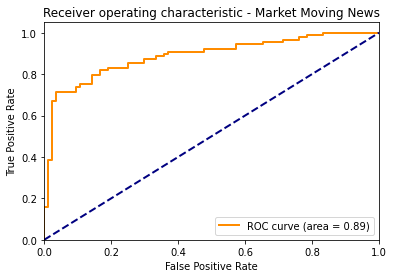

In [16]:
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in [0, 1]:
    if i == 1:
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    else:
        fpr[i], tpr[i], _ = roc_curve(~y_test, 1-y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Receiver operating characteristic - {feature_name}")
plt.legend(loc="lower right")
plt.show()

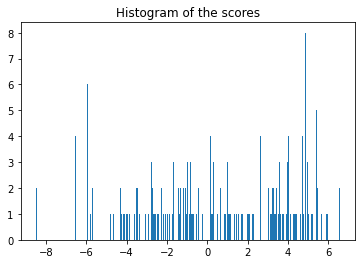

In [17]:
_ = plt.hist(y_score, bins=300)
_ = plt.title("Histogram of the scores")

# 4. Most impactful words from the classifier [must use a linear classifier]

Displays the largest (in absolute value) coefficients from the classifiers.

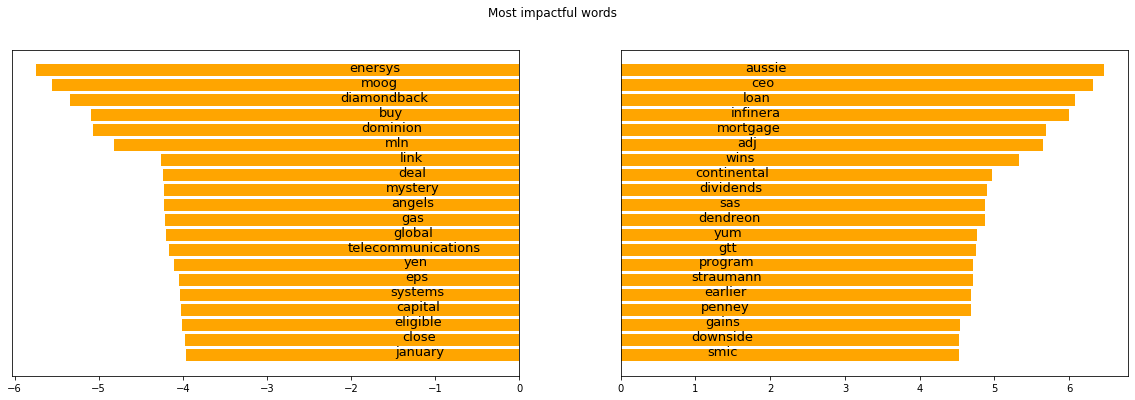

In [18]:
coefs = dict(zip(
    estimator.named_steps['vectorizer'].get_feature_names_out(),
    estimator.named_steps['classifier'].coef_.squeeze().tolist()
))

bottom, top = get_topk(
    coef=list(coefs.values()),
    words=list(coefs.keys()),
    k=20
)

word_ranking(top, bottom)

# 5. Displaying a few examples from the test set (near and far away from classification boundary)

Get a few examples from the test dataset. I pick examples that are the most likely and less likely to be classified as analyst, ad well as ambiguous examples.

In [19]:
NB_EXAMPLES = 20
predicted_df = pd.concat({
    'headline': pd.Series(X_test.values),
    #'body': pd.Series(df.iloc[X_test.index]["clean_body"].values),
    'score': pd.Series(y_score),
    'ground_truth': pd.Series(y_test.values)
}, axis=1).drop_duplicates('headline').sort_values('score')

In [20]:
print(f'{NB_EXAMPLES} EXAMPLES LESS LIKELY TO BE {feature_name}')
for row in predicted_df.head(NB_EXAMPLES).itertuples():
    print(f'- {row.headline} [{row.ground_truth}]')
    
print(f'\n{NB_EXAMPLES} EXAMPLES MOST LIKELY TO BE {feature_name}')
for row in predicted_df.tail(NB_EXAMPLES).itertuples():
    print(f'- {row.headline} [{row.ground_truth}]')
    
predicted_df = predicted_df.assign(
    abs_score = np.abs(predicted_df["score"])
).sort_values('abs_score')

print(f'\n{NB_EXAMPLES} EXAMPLES MOST AMBIGUOUS')
for row in predicted_df.head(NB_EXAMPLES).itertuples():
    print(f'- {row.headline} [{row.ground_truth}]')

20 EXAMPLES LESS LIKELY TO BE Market Moving News
- market on close imbalance buy shares [False]
- market on close eligible [False]
- market on close imbalance sell shares [False]
- ca technologies may buy back shrs up to b [False]
- midas holdings fy sales s mln vs s mln [False]
- audley capital nominates five for walter energy board [True]
- bmo capital markets equity through education trading day [False]
- lundin petroleum raised to buy from hold at seb enskilda [False]
- kingtone wirelessinfo q revenue m [False]
- aareal bank rises at tradegate vs xetra close [False]
- groupon sees fy rev b to b saw b b [True]
- waskita karya persero shares rise at open in jakarta [False]
- wnedel says successfully sold eu mln of bonds [False]
- cardiovascular systems q rev m est m [True]
- quanta s may notebook shipments million [False]
- centurylink sees q eps c c [False]
- anglo restarting chile copper mine after contractors dispute [False]
- mobile telesystems ojsc announced deal on web site dec

# 6. Examples that are missclassified

In [21]:
predicted_df = predicted_df.assign(
    prediction = (predicted_df["score"] > 0)
)
predicted_df = predicted_df.assign(
    error = ~predicted_df["prediction"].eq(predicted_df["ground_truth"])
)

print(f'\n{NB_EXAMPLES} MISSCLASIFIED EXAMPLES WHERE CONFIDENCE IN PREDICTION WAS LARGEST')
for row in predicted_df[predicted_df['error']].sort_values("abs_score", ascending=False).head(NB_EXAMPLES).itertuples():
    print(f'- {row.headline.upper()}')
    print(f'  [classified as {row.prediction} with {round(row.score, 1)} but was in fact {row.ground_truth}]')


20 MISSCLASIFIED EXAMPLES WHERE CONFIDENCE IN PREDICTION WAS LARGEST
- AUDLEY CAPITAL NOMINATES FIVE FOR WALTER ENERGY BOARD
  [classified as False with -5.7 but was in fact True]
- MAST THERAPEUTICS M UNIT OFFERING PRICED AT C DOWN
  [classified as True with 5.0 but was in fact False]
- GROUPON SEES FY REV B TO B SAW B B
  [classified as False with -4.3 but was in fact True]
- OIL FUTURES DECLINE IN NEW YORK ERASING EARLIER ADVANCE OF
  [classified as True with 4.1 but was in fact False]
- CARDIOVASCULAR SYSTEMS Q REV M EST M
  [classified as False with -4.0 but was in fact True]
- VERIFONE SYSTEMS INC OUTLOOK TO STABLE FROM POSITIVE BY S P
  [classified as False with -3.5 but was in fact True]
- FORTESCUE CEO SEES STABILITY IN CHINA IRON ORE DEMAND
  [classified as True with 3.1 but was in fact False]
- ANSYS CUT TO NEUTRAL VS BUY AT CL KING
  [classified as False with -2.7 but was in fact True]
- GOLD PRICE MAY DECLINE THIS YEAR FROM RECORD HERZ SAYS
  [classified as True with 2.6 

# 7. Misc. explorations

Placeholder for more exploration